## Analisis variables fisicas (Temperatura, Presion, Humedad) vs Estimacion de Poblacion  en Region Metropolitana 

## variables fisicas (Temperatura, Presion, Humedad) ##

In [1]:
# import librerias
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
from zipfile import ZipFile
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
# Pre Descarga informacion Temperatura, humedad, presion Region metropolitana estacion Tobalaba (330019)

urlbase= 'https://climatologia.meteochile.gob.cl/application/historico/datosDescarga/330021'
pagebase = requests.get(urlbase)
soup = BeautifulSoup(pagebase.content, "html.parser")
results=soup.findAll('a')

links =[x['href'] for x in results]        
dato=[x for x in links if '/application/datos/' in x]       

temperaturaLink=[('https://climatologia.meteochile.gob.cl'+x) for x in links if '_Temperatura_' in x]  
humedadLink=[('https://climatologia.meteochile.gob.cl'+x) for x in links if '_Humedad_' in x]   
presionLink=[('https://climatologia.meteochile.gob.cl'+x) for x in links if '_PresionQFF_' in x] 

In [3]:
# Funcion descarga informacion Temperatura, humedad, presion
def getDatos(x):
        zipresp = urlopen(x)
            # Create a tempfile
        tempzip = open("/tmp/file.zip", "wb")
            # Write 
        tempzip.write(zipresp.read())
            # Close 
        tempzip.close()
            # Re-open 
        zf = ZipFile("/tmp/file.zip")
            # Extract its contents,  automatic creation of path
        zf.extractall(path = 'csv')
            # close the ZipFile instance
        zf.close()

In [4]:
# Descarga informacion Temperatura, humedad, presion
fileNamesTemp=[]
fileNamesHum=[]
fileNamesPres=[]

for x in temperaturaLink:
    fileNamesTemp.append(x.split('/')[-1].strip()+'.csv')
    getDatos(x)

for x in humedadLink:
    fileNamesHum.append(x.split('/')[-1].strip()+'.csv')
    getDatos(x)

for x in presionLink:
    fileNamesPres.append(x.split('/')[-1].strip()+'.csv')
    getDatos(x)   

In [5]:
# Leer csv y generar base datos variables fisicas
# Convertir fechas to DateTime
def makeDataframes(fileNames, variable):
    headers = ['codigoNac', 'fecha', 'hora', variable]
    df = pd.DataFrame()
    for file in fileNames:
        _ = pd.read_csv('csv/'+file, sep = '[;, ,]', engine = 'python', index_col=False, names=headers)
        _.drop([0], inplace=True)
        df=_.append(df, ignore_index=True)
    
    df['fecha'] = df[['fecha', 'hora']].apply(' '.join, axis=1)
    df.drop(['hora'], axis=1, inplace=True)
    
    df['fecha']=pd.to_datetime(df['fecha'], format='%d-%m-%Y %H:%M:%S')
    
    return df

In [6]:
dfTemp=makeDataframes(fileNamesTemp, 'temperatura')
dfHum=makeDataframes(fileNamesHum, 'humedad')
dfPres=makeDataframes(fileNamesPres, 'presion')

df_temp = dfTemp.merge(dfHum,on=['fecha', 'codigoNac']).merge(dfPres,on=['fecha', 'codigoNac'])
df_temp['year']=[x.year for x in  df_temp['fecha']]

In [7]:
df=df_temp[(df_temp['year']>=2002) & (df_temp['year']<2022)]
#df.to_csv('df_temp.csv',index=False)
df.head()

,codigoNac,fecha,temperatura,humedad,presion,year
1707232,330021,2002-01-01,23.2,46.0,1011.6,2002
1707233,330021,2002-01-01,23.2,46.0,1011.6,2002
1707234,330021,2002-01-01,23.2,46.0,1011.6,2002
1707235,330021,2002-01-01,23.2,46.0,1011.6,2002
1707236,330021,2002-01-01,23.2,46.0,1011.6,2002


In [8]:
# Grupos variables fisicas
def makeGrups(df, freq):
    df1=df.groupby(pd.Grouper(key='fecha', axis=0, freq=freq)).max().rename(columns={'temperatura':'maxTemp', 'humedad':'maxHum', 'presion':'maxPres'})
    df2=df.groupby(pd.Grouper(key='fecha', axis=0, freq=freq)).min().rename(columns={'temperatura':'minTemp', 'humedad':'minHum', 'presion':'minPres'})
    df3=df.groupby(pd.Grouper(key='fecha', axis=0, freq=freq)).mean().rename(columns={'temperatura':'meanTemp', 'humedad':'meanHum', 'presion':'meanPres'})
    dffreq = df1.merge(df2,on=['fecha', 'codigoNac']).merge(df3,on='fecha')
    
    return dffreq    

In [9]:
# obtenemos los valores max, min, mean diarios
dfDay = makeGrups(df, 'd')  
dfDay.reset_index(inplace=True)
dfDay.drop(['year_x', 'year_y'], axis=1, inplace=True)
dfDay=dfDay[['fecha','codigoNac','maxTemp','minTemp','meanTemp','maxHum','minHum','meanHum','maxPres','minPres','meanPres']]
#dfDay.to_csv('df_temp_day.csv',index=False)
dfDay.head()

,fecha,codigoNac,maxTemp,minTemp,meanTemp,maxHum,minHum,meanHum,maxPres,minPres,meanPres
0,2002-01-01,330021,27.8,14.6,21.0250,80.0,38.0,57.125,1015.9,1011.6,1013.7250
1,2002-01-02,330021,29.2,13.6,21.0875,88.0,38.0,60.750,1018.0,1012.8,1015.7000
2,2002-01-03,330021,29.5,13.9,22.2500,71.0,33.0,47.375,1016.2,1010.8,1014.0875
3,2002-01-04,330021,27.4,15.3,21.0625,48.0,25.0,35.875,1018.0,1012.7,1015.4375
4,2002-01-05,330021,31.3,12.2,21.4250,66.0,22.0,42.125,1017.9,1010.7,1015.5625


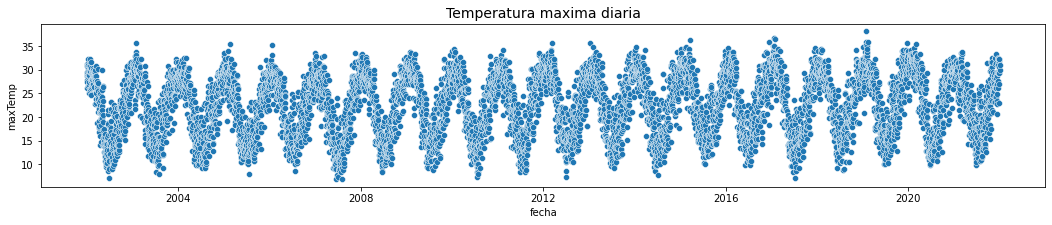

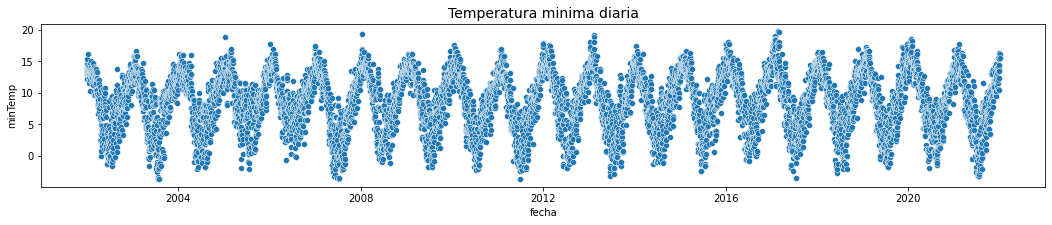

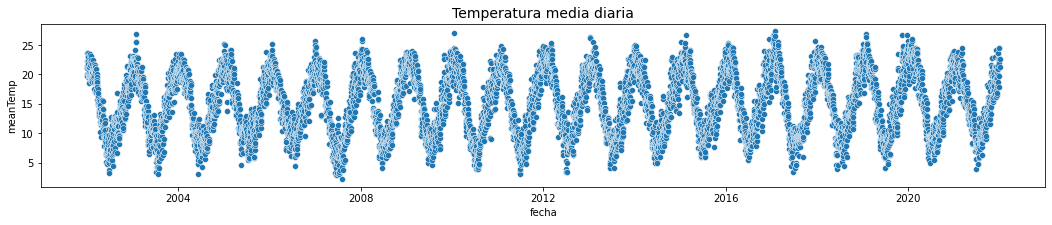

In [10]:
# Graficos temperatura diaria
plt.figure(figsize=(18, 3))
plt.title('Temperatura maxima diaria', size=14);
sns.scatterplot(data=dfDay, x=dfDay['fecha'], y=dfDay['maxTemp'])
plt.show()
plt.figure(figsize=(18, 3))
plt.title('Temperatura minima diaria', size=14);
sns.scatterplot(data=dfDay, x=dfDay['fecha'], y=dfDay['minTemp'])
plt.show()
plt.figure(figsize=(18, 3))
plt.title('Temperatura media diaria', size=14);
sns.scatterplot(data=dfDay, x=dfDay['fecha'], y=dfDay['meanTemp'])
plt.show()

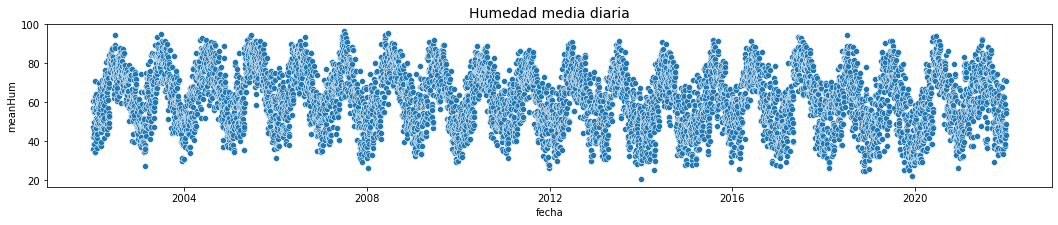

In [11]:
# Graficos humedad media diaria
plt.figure(figsize=(18, 3))
plt.title('Humedad media diaria', size=14);
sns.scatterplot(data=dfDay, x=dfDay['fecha'], y=dfDay['meanHum'])
plt.show()

In [12]:
dfDay.sort_index(inplace=True)
y_mean = dfDay.rolling(30,min_periods=30).mean().dropna()
y_mean.head(2)

,codigoNac,maxTemp,minTemp,meanTemp,maxHum,minHum,meanHum,maxPres,minPres,meanPres
29,330021.0,28.883333,13.426667,21.199762,74.533333,29.366667,49.832738,1015.243333,1010.10,1013.105179
30,330021.0,29.010000,13.280000,21.173929,74.166667,28.600000,49.145238,1015.240000,1009.98,1013.083095


- El problema con esta forma, se pierde los datos de fechas
- se usara groupby (grouper) con los datos ya agrupados por dia.

In [13]:
# obtenemos los valores mean cada 5 años (con el objetivo de suavizar la curva y obtener la tendencia)
dfYear=dfDay.groupby(pd.Grouper(key='fecha', axis=0, freq='5y')).mean().add_suffix('Mean')
dfYear.reset_index(inplace=True)
#dfYear.to_csv('df_temp_year.csv',index=False)
dfYear.head()

,fecha,maxTempMean,minTempMean,meanTempMean,maxHumMean,minHumMean,meanHumMean,maxPresMean,minPresMean,meanPresMean
0,2002-12-31,21.376438,8.264932,14.447754,85.712329,41.013699,65.081800,1018.564110,1013.272055,1016.344775
1,2007-12-31,21.681051,8.442388,14.624035,85.754107,40.370208,64.886501,1018.761336,1013.245619,1016.476828
2,2012-12-31,22.466284,8.534428,15.024800,83.298851,36.724466,61.812677,1018.495238,1012.743021,1016.116400
3,2017-12-31,22.895071,8.825411,15.395296,81.547645,34.794633,59.898193,1018.546769,1012.637240,1016.073974
4,2022-12-31,23.571937,8.731211,15.681412,81.592060,32.635866,58.683360,1018.513142,1012.647365,1016.017000


In [14]:
# obtenemos los valores maximos cada 5 años (con el objetivo de suavizar la curva y obtener la tendencia)
dfYearMax=dfDay.groupby(pd.Grouper(key='fecha', axis=0, freq='5y')).max().add_suffix('Max')
dfYearMax.reset_index(inplace=True)
dfYearMax.drop(['codigoNacMax'], axis=1, inplace=True)
dfYearMax.head()

,fecha,maxTempMax,minTempMax,meanTempMax,maxHumMax,minHumMax,meanHumMax,maxPresMax,minPresMax,meanPresMax
0,2002-12-31,32.4,16.1,23.7125,97.0,82.0,94.375,1031.7,1024.9,1028.150000
1,2007-12-31,35.6,18.9,26.8375,100.0,91.0,96.375,1032.7,1025.9,1029.662500
2,2012-12-31,35.6,19.4,27.0625,100.0,89.0,95.500,1041.5,1027.8,1030.275000
3,2017-12-31,36.7,19.8,27.3750,100.0,89.0,93.625,1054.6,1028.6,1030.495833
4,2022-12-31,38.2,18.5,26.8625,100.0,85.0,94.375,1032.2,1024.7,1029.416667


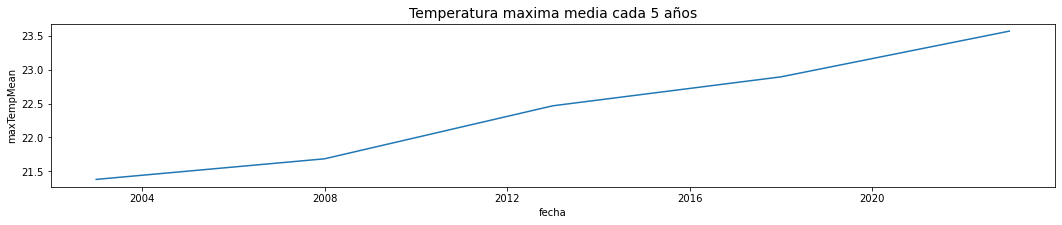

In [15]:
# Graficos temperatura maxima media cada 5 años
plt.figure(figsize=(18, 3))
plt.title('Temperatura maxima media cada 5 años', size=14);
sns.lineplot(data=dfYear, x=dfYear['fecha'], y=dfYear['maxTempMean'])
plt.show()

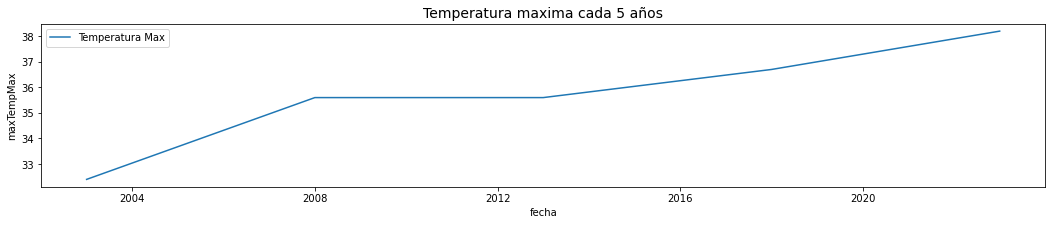

In [16]:
# Graficos temperatura maxima (valor maximo) cada 5 años
plt.figure(figsize=(18, 3))
plt.title('Temperatura maxima cada 5 años', size=14);
sns.lineplot(data=dfYearMax, x=dfYearMax['fecha'], y=dfYearMax['maxTempMax'], label='Temperatura Max')
plt.legend()
plt.xticks(rotation=0);

- Temperatura maxima a aumentado alrededor de 6 grados en los ultimos 20 años.

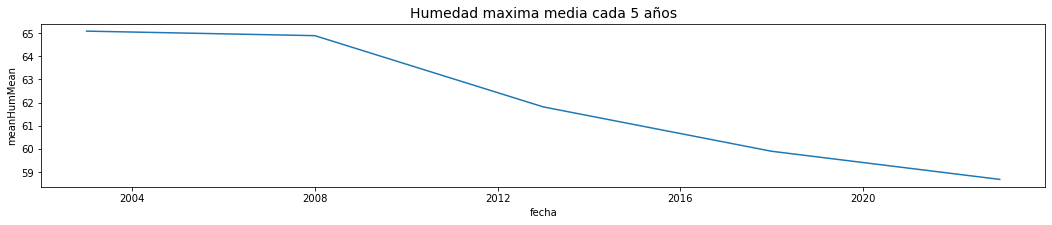

In [17]:
# Graficos maxima maxima media cada 5 años
plt.figure(figsize=(18, 3))
plt.title('Humedad maxima media cada 5 años', size=14);
sns.lineplot(data=dfYear, x=dfYear['fecha'], y=dfYear['meanHumMean'])
plt.show()

## Poblacion ##

In [18]:
# Leer csv estimacion de poblacion 
# https://www.ine.cl/estadisticas/sociales/demografia-y-vitales/proyecciones-de-poblacion

dp=pd.read_excel('estimaciones-y-proyecciones-2002-2035-comunas.xlsx')
dp.head()

,Region,Nombre Region,Provincia,Nombre Provincia,Comuna,Nombre Comuna,Sexo\n1=Hombre\n2=Mujer,Edad,Poblacion 2002,Poblacion 2003,...,Poblacion 2026,Poblacion 2027,Poblacion 2028,Poblacion 2029,Poblacion 2030,Poblacion 2031,Poblacion 2032,Poblacion 2033,Poblacion 2034,Poblacion 2035
0,1,Tarapacá,11,Iquique,1101,Iquique,1,0,1469,1395,...,1518,1500,1483,1466,1446,1441,1425,1410,1395,1378
1,1,Tarapacá,11,Iquique,1101,Iquique,1,1,1472,1379,...,1523,1507,1489,1470,1454,1434,1429,1413,1397,1383
2,1,Tarapacá,11,Iquique,1101,Iquique,1,2,1461,1377,...,1526,1509,1492,1477,1458,1440,1420,1412,1401,1383
3,1,Tarapacá,11,Iquique,1101,Iquique,1,3,1464,1376,...,1521,1508,1491,1474,1457,1439,1422,1401,1395,1380
4,1,Tarapacá,11,Iquique,1101,Iquique,1,4,1462,1382,...,1514,1503,1489,1472,1456,1438,1418,1403,1383,1376


In [19]:
dp.rename({'Sexo\n1=Hombre\n2=Mujer': 'sexo'}, axis=1, inplace=True) 

In [20]:
dp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56052 entries, 0 to 56051
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Region            56052 non-null  int64 
 1   Nombre Region     56052 non-null  object
 2   Provincia         56052 non-null  int64 
 3   Nombre Provincia  56052 non-null  object
 4   Comuna            56052 non-null  int64 
 5   Nombre Comuna     56052 non-null  object
 6   sexo              56052 non-null  int64 
 7   Edad              56052 non-null  int64 
 8   Poblacion 2002    56052 non-null  int64 
 9   Poblacion 2003    56052 non-null  int64 
 10  Poblacion 2004    56052 non-null  int64 
 11  Poblacion 2005    56052 non-null  int64 
 12  Poblacion 2006    56052 non-null  int64 
 13  Poblacion 2007    56052 non-null  int64 
 14  Poblacion 2008    56052 non-null  int64 
 15  Poblacion 2009    56052 non-null  int64 
 16  Poblacion 2010    56052 non-null  int64 
 17  Poblacion 20

In [21]:
dp.columns

Index(['Region', 'Nombre Region', 'Provincia', 'Nombre Provincia', 'Comuna',
       'Nombre Comuna', 'sexo', 'Edad', 'Poblacion 2002', 'Poblacion 2003',
       'Poblacion 2004', 'Poblacion 2005', 'Poblacion 2006', 'Poblacion 2007',
       'Poblacion 2008', 'Poblacion 2009', 'Poblacion 2010', 'Poblacion 2011',
       'Poblacion 2012', 'Poblacion 2013', 'Poblacion 2014', 'Poblacion 2015',
       'Poblacion 2016', 'Poblacion 2017', 'Poblacion 2018', 'Poblacion 2019',
       'Poblacion 2020', 'Poblacion 2021', 'Poblacion 2022', 'Poblacion 2023',
       'Poblacion 2024', 'Poblacion 2025', 'Poblacion 2026', 'Poblacion 2027',
       'Poblacion 2028', 'Poblacion 2029', 'Poblacion 2030', 'Poblacion 2031',
       'Poblacion 2032', 'Poblacion 2033', 'Poblacion 2034', 'Poblacion 2035'],
      dtype='object')

In [22]:
col=['Nombre Region', 'Poblacion 2002', 'Poblacion 2003', 'sexo',
       'Poblacion 2004', 'Poblacion 2005', 'Poblacion 2006', 'Poblacion 2007',
       'Poblacion 2008', 'Poblacion 2009', 'Poblacion 2010', 'Poblacion 2011',
       'Poblacion 2012', 'Poblacion 2013', 'Poblacion 2014', 'Poblacion 2015',
       'Poblacion 2016', 'Poblacion 2017', 'Poblacion 2018', 'Poblacion 2019',
       'Poblacion 2020', 'Poblacion 2021', 'Poblacion 2022', 'Poblacion 2023',
       'Poblacion 2024', 'Poblacion 2025', 'Poblacion 2026', 'Poblacion 2027',
       'Poblacion 2028', 'Poblacion 2029', 'Poblacion 2030', 'Poblacion 2031',
       'Poblacion 2032', 'Poblacion 2033', 'Poblacion 2034', 'Poblacion 2035']

In [23]:
dp['Nombre Region'].unique()

array(['Tarapacá', 'Antofagasta', 'Atacama', 'Coquimbo', 'Valparaíso',
       "Libertador General Bernardo O'Higgins", 'Maule', 'Biobío',
       'La Araucanía', 'Los Lagos',
       'Aysén del General Carlos Ibáñez del Campo',
       'Magallanes y de la Antártica Chilena',
       'Metropolitana de Santiago', 'Los Ríos', 'Arica y Parinacota',
       'Ñuble'], dtype=object)

In [24]:
dpm=dp[dp['Nombre Region']=='Metropolitana de Santiago'][col]
dpm

,Nombre Region,Poblacion 2002,Poblacion 2003,sexo,Poblacion 2004,Poblacion 2005,Poblacion 2006,Poblacion 2007,Poblacion 2008,Poblacion 2009,...,Poblacion 2026,Poblacion 2027,Poblacion 2028,Poblacion 2029,Poblacion 2030,Poblacion 2031,Poblacion 2032,Poblacion 2033,Poblacion 2034,Poblacion 2035
41634,Metropolitana de Santiago,1362,1422,1,1466,1499,1569,1675,1797,1901,...,2864,2869,2866,2858,2844,2848,2832,2813,2790,2765
41635,Metropolitana de Santiago,1338,1388,1,1444,1482,1513,1579,1683,1799,...,2778,2788,2790,2786,2775,2759,2758,2740,2717,2691
41636,Metropolitana de Santiago,1273,1317,1,1362,1412,1447,1474,1536,1632,...,2615,2630,2638,2638,2631,2618,2599,2596,2575,2550
41637,Metropolitana de Santiago,1213,1238,1,1276,1312,1357,1387,1409,1463,...,2412,2431,2443,2448,2446,2437,2422,2401,2394,2372
41638,Metropolitana de Santiago,1160,1189,1,1209,1240,1273,1313,1339,1356,...,2243,2268,2285,2294,2297,2293,2282,2264,2241,2232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50053,Metropolitana de Santiago,109,121,2,131,140,147,152,155,158,...,301,338,355,369,380,394,408,422,433,444
50054,Metropolitana de Santiago,97,109,2,120,130,138,144,148,151,...,267,287,322,338,351,362,376,389,402,413
50055,Metropolitana de Santiago,88,98,2,109,119,128,135,140,144,...,249,253,272,305,320,333,344,356,369,382
50056,Metropolitana de Santiago,77,86,2,95,105,114,122,129,133,...,223,233,237,254,285,300,312,322,334,346


In [25]:
dpm_sexo=dpm.groupby('sexo').sum()
dpm_sexo.reset_index(inplace=True)
dpm_sexo.drop(['sexo'], axis=1, inplace=True)
dpm_sexo=dpm_sexo.T.reset_index()
dpm_sexo.rename({'index': 'year', 0: 'hombres', 1: 'mujeres'}, axis=1, inplace=True) 
dpm_sexo['year'].replace('Poblacion', ' ', inplace=True, regex=True)
#dpm_sexo['year']=pd.to_datetime(dpm_sexo['year'], format=' %Y')
dpm_sexo=dpm_sexo.astype({"year": int})
dpm_sexo.head()

,year,hombres,mujeres
0,2002,3059467,3246180
1,2003,3097915,3281853
2,2004,3136310,3317651
3,2005,3173126,3352032
4,2006,3210620,3387078


In [26]:
dpm_total=dpm.groupby('Nombre Region').sum()
dpm_total.reset_index(inplace=True)
dpm_total.drop(['Nombre Region', 'sexo'], axis=1, inplace=True)
dpm_total=dpm_total.T.reset_index()
dpm_total.rename({'index': 'year', 0: 'poblacion'}, axis=1, inplace=True) 
dpm_total['year'].replace('Poblacion', ' ', inplace=True, regex=True)
dpm_total=dpm_total.astype({"year": int})
#dpm_total['year']=pd.to_datetime(dpm_total['year'], format='%Y')

dpm_total.head()

,year,poblacion
0,2002,6305647
1,2003,6379768
2,2004,6453961
3,2005,6525158
4,2006,6597698


In [27]:
dpm_sexo2002=dpm_sexo[(dpm_sexo['year']>=2002) & (dpm_sexo['year']<2022)].copy()
dpm_total2002=dpm_total[(dpm_total['year']>=2002) & (dpm_total['year']<2022)].copy()

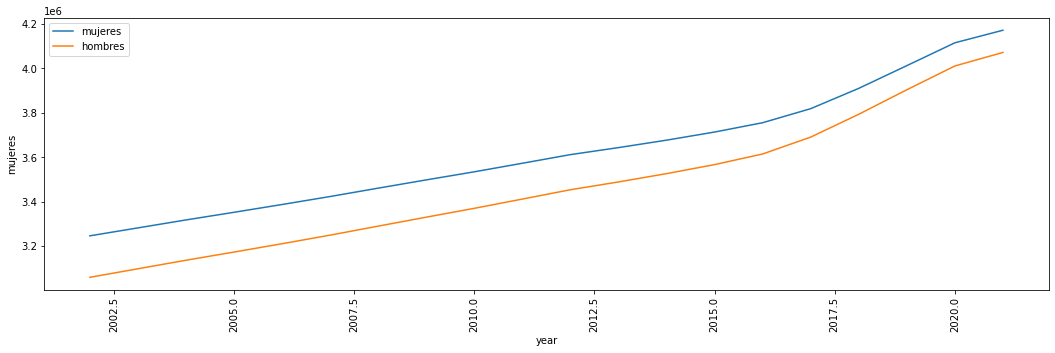

In [28]:
# Grafico poblacion femenina y masculina proyectada
plt.figure(figsize=(18, 5))
sns.lineplot(data=dpm_sexo2002, x='year', y='mujeres', legend=True, label='mujeres');
sns.lineplot(data=dpm_sexo2002, x='year', y='hombres', legend=True, label='hombres');
plt.legend()
plt.xticks(rotation=90);

- Poblacion femenina en RM es mayor a la masculina, con una leve tendencia a estrecharse

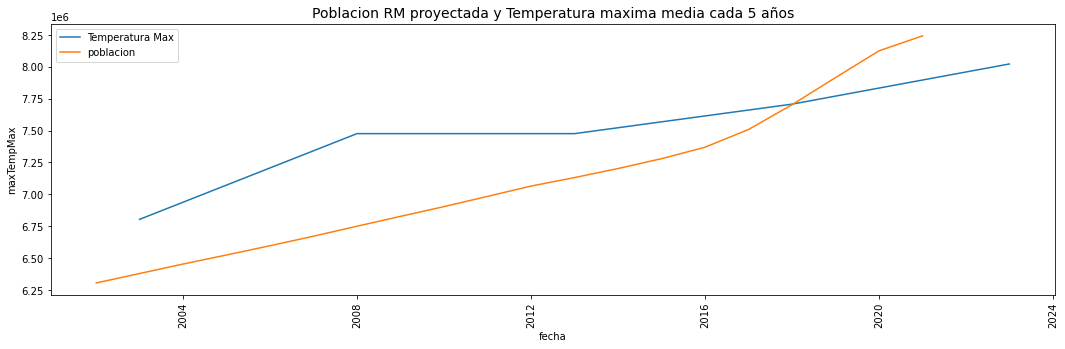

In [29]:
# Poblacion RM proyectada y Temperatura maxima media cada 5 años
dpm_total2002['year']=pd.to_datetime(dpm_total['year'], format='%Y')
plt.figure(figsize=(18, 5))
plt.title('Poblacion RM proyectada y Temperatura maxima media cada 5 años', size=14);
#sns.lineplot(data=dfYear, x=dfYear['fecha'], y=dfYear['maxTempMean']*300000, label='Temperatura Max Mean')
sns.lineplot(data=dfYearMax, x=dfYearMax['fecha'], y=dfYearMax['maxTempMax']*210000, label='Temperatura Max')
sns.lineplot(data=dpm_total2002, x=dpm_total2002['year'], y=dpm_total2002['poblacion'], legend=True, label='poblacion');
plt.legend(loc='upper left')
plt.xticks(rotation=90);

- Valores de temperatura ajustados para analisis visual

- Se observa una tendencia de aumento de la temperatura junto al aumento de la poblacion, si bien, una variable no gatilla la otra directamente, se entiende que existen eventos comunes relacionadas al calentamiento global donde interactuan estas variables
-  A no gatilla B, o viceversa, pero ambas se relacionan a C